In [1]:
# !pip install mpl_finance
# !pip install yfinance

In [2]:
%matplotlib inline
from lstm import *
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import yfinance as yf

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt


from Constants import Consts

/home/eytan/miniconda/envs/data-science/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# from google.colab import drive
# drive.mount('/content/drive')

device(type='cpu')

## Adding gold and VIX (Volatility Index) to augment our stock data

In [4]:
prev_5_years = (datetime.today() - timedelta(days=1825)).strftime('%Y-%m-%d')
today = datetime.today().strftime('%Y-%m-%d')

gold_etf = yf.Ticker('GLD')
gold_etf_data = gold_etf.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
gold_etf_data['date_timestamp'] = dates.date2num(gold_etf_data.index)
gold_etf_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-24,102.820000,103.050003,102.769997,103.050003,1710200,16793.0
2015-12-28,102.480003,102.599998,102.029999,102.269997,3356200,16797.0
2015-12-29,102.519997,102.580002,102.110001,102.199997,2832200,16798.0
2015-12-30,101.470001,101.599998,101.349998,101.419998,3745000,16799.0
2015-12-31,101.480003,101.720001,101.309998,101.459999,3823600,16800.0
...,...,...,...,...,...,...
2020-12-16,174.130005,175.020004,173.020004,174.899994,8174700,18612.0
2020-12-17,177.149994,177.869995,176.580002,176.740005,9475800,18613.0
2020-12-18,176.649994,176.979996,176.100006,176.440002,6789900,18614.0


In [5]:
vix_index = yf.Ticker('^VIX')
vix_data = vix_index.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
vix_data['date_timestamp'] = dates.date2num(vix_data.index)
vix_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-24,15.440000,15.880000,14.450000,15.740000,0,16793.0
2015-12-28,17.650000,18.129999,16.879999,16.910000,0,16797.0
2015-12-29,15.910000,16.480000,15.630000,16.080000,0,16798.0
2015-12-30,16.500000,17.420000,16.500000,17.290001,0,16799.0
2015-12-31,17.969999,20.389999,17.510000,18.209999,0,16800.0
...,...,...,...,...,...,...
2020-12-16,22.510000,23.670000,22.290001,22.500000,0,18612.0
2020-12-17,21.980000,22.270000,21.520000,21.930000,0,18613.0
2020-12-18,22.150000,23.770000,21.570000,21.570000,0,18614.0


In [6]:
apple = yf.Ticker('AAPL')
apple_data = apple.history(start=prev_5_years, end=today, auto_adjust=True, actions=False)
apple_data['date_timestamp'] = dates.date2num(apple_data.index)

first_date = apple_data.iloc[0].name

apple_data

,Open,High,Low,Close,Volume,date_timestamp
Date,,,,,,
2015-12-24,25.246347,25.246347,25.003147,25.021677,54281600,16793.0
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,16797.0
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800,16798.0
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200,16799.0
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200,16800.0
...,...,...,...,...,...,...
2020-12-16,127.410004,128.369995,126.559998,127.809998,98208600,18612.0
2020-12-17,128.899994,129.580002,128.039993,128.699997,94359800,18613.0
2020-12-18,128.960007,129.100006,126.120003,126.660004,192541500,18614.0


In [7]:
apple_data['gold_close'] = gold_etf_data.Close
apple_data['vix_close'] = vix_data.Close

In [8]:
apple_data

,Open,High,Low,Close,Volume,date_timestamp,gold_close,vix_close
Date,,,,,,,,
2015-12-24,25.246347,25.246347,25.003147,25.021677,54281600,16793.0,103.050003,15.740000
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,16797.0,102.269997,16.910000
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800,16798.0,102.199997,16.080000
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200,16799.0,101.419998,17.290001
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200,16800.0,101.459999,18.209999
...,...,...,...,...,...,...,...,...
2020-12-16,127.410004,128.369995,126.559998,127.809998,98208600,18612.0,174.899994,22.500000
2020-12-17,128.899994,129.580002,128.039993,128.699997,94359800,18613.0,176.740005,21.930000
2020-12-18,128.960007,129.100006,126.120003,126.660004,192541500,18614.0,176.440002,21.570000


In [9]:
apple_close_delta = apple_data.Close.diff()[1:]
apple_close_delta

Date
2015-12-28   -0.280258
2015-12-29    0.444706
2015-12-30   -0.328896
2015-12-31   -0.477137
2016-01-04    0.020849
                ...   
2020-12-16   -0.070000
2020-12-17    0.889999
2020-12-18   -2.039993
2020-12-21    1.569992
2020-12-22    3.650009
Name: Close, Length: 1257, dtype: float64

In [10]:
# Make the positive gains (up) and negative gains (down) Series
up, down = apple_close_delta.copy(), apple_close_delta.copy()
up[up < 0] = 0
down[down > 0] = 0

In [11]:
window_length = 14

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))
RSI1

Date
2015-12-28     0.000000
2015-12-29    64.675436
2015-12-30    41.674595
2015-12-31    26.123334
2016-01-04    27.487608
                ...    
2020-12-16    72.354722
2020-12-17    74.456663
2020-12-18    61.991005
2020-12-21    66.910480
2020-12-22    75.438258
Name: Close, Length: 1257, dtype: float64

In [12]:
try:
    apple_data.drop(index=first_date, inplace=True)
except KeyError:
    pass

In [13]:
apple_data['RSI'] = RSI1
apple_data.head()

,Open,High,Low,Close,Volume,date_timestamp,gold_close,vix_close,RSI
Date,,,,,,,,,
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800,16797.0,102.269997,16.910000,0.000000
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800,16798.0,102.199997,16.080000,64.675436
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200,16799.0,101.419998,17.290001,41.674595
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200,16800.0,101.459999,18.209999,26.123334
2016-01-04,23.766309,24.405575,23.625022,24.400942,270597600,16804.0,102.889999,20.700001,27.487608


In [14]:
# Create a list of lists where each inner-list represents
# one day's trading history
apple = apple_data[[Consts.DATE_TIMESTAMP, Consts.OPEN, Consts.HIGH, 
                    Consts.LOW, Consts.CLOSE, Consts.VOLUME, 'gold_close', 'vix_close', 'RSI']]
apple_list = apple.values.tolist()

# Plot a candlestick chart for Apples stock

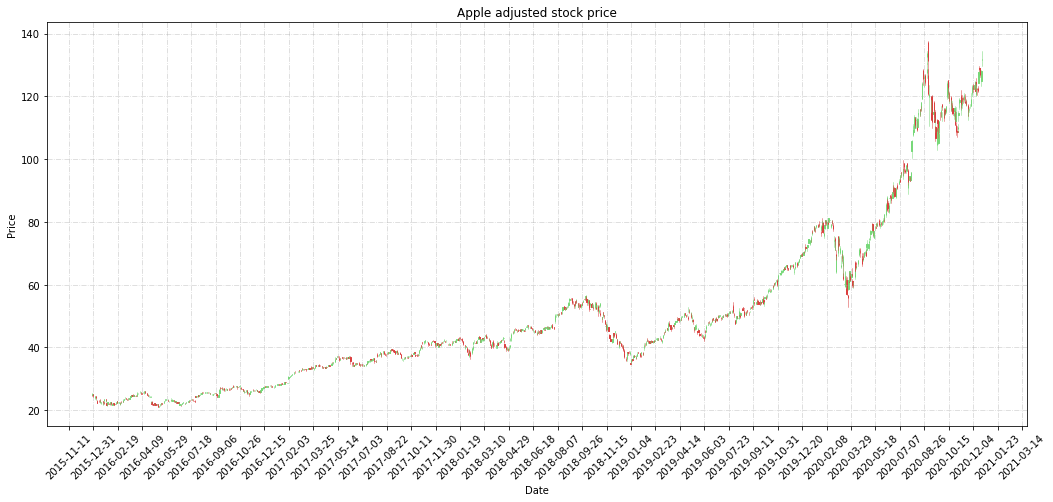

In [15]:

# Build the plot
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((1,1), (0,0))

candlestick_ohlc(ax1, apple_list, width=0.4, colorup='#77d879', colordown='#db3f3f',)

for label in ax1.xaxis.get_ticklabels():
     label.set_rotation(45)

ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(50))
ax1.grid(True, alpha=0.5, linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple adjusted stock price')
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

# Scaling the data

In [16]:
desired_columns = ['Open', 'High', 'Low', 'Close', 'Volume'] #, 'gold_close', 'vix_close', 'RSI']
close_idx = desired_columns.index('Close')
apple = apple[desired_columns]
apple

,Open,High,Low,Close,Volume
Date,,,,,
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200
2016-01-04,23.766309,24.405575,23.625022,24.400942,270597600
...,...,...,...,...,...
2020-12-16,127.410004,128.369995,126.559998,127.809998,98208600
2020-12-17,128.899994,129.580002,128.039993,128.699997,94359800
2020-12-18,128.960007,129.100006,126.120003,126.660004,192541500


#### Split the data into training and testing sets

In [17]:
test_size = 365
data = apple.values

train_data = data[:-test_size]
test_data = data[-test_size:]

In [18]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
train_data = torch.FloatTensor(train_data).to(device)

len(train_data), train_data[:3]

(892,
 tensor([[-1.2429, -1.2609, -1.2585, -1.2640, -0.3984],
         [-1.2581, -1.2193, -1.2419, -1.2175, -0.1117],
         [-1.2190, -1.2367, -1.2340, -1.2519, -0.4995]]))

In [19]:
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data)
test_data = torch.FloatTensor(test_data).to(device)

len(test_data), test_data[:3]

(365,
 tensor([[-1.3000, -1.3116, -1.2966, -1.3097, -1.0816],
         [-1.3054, -1.3216, -1.2989, -1.3213, -1.2456],
         [-1.3059, -1.3138, -1.2945, -1.2981, -0.9820]]))

# Creating our data for training

In [20]:
# we split the data into 100 day sequences
seq_len = 100
train_seq = create_sequences(train_data, seq_len, close_idx)
print(f'There are {len(train_seq)} training sequences where each sequence has a shape of {train_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 792 training sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [21]:
test_seq = create_sequences(test_data, seq_len, close_idx)
print(f'There are {len(test_seq)} testing sequences where each sequence has a shape of {test_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 265 testing sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [22]:
model = LSTM_linear_before_after(len(desired_columns), 100, 1).to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM_linear_before_after(
  (fc2): Linear(in_features=5, out_features=32, bias=True)
  (lstm): LSTM(32, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)


In [23]:
epochs = 15

loss_history = []
running_loss = []
for i in range(epochs):
    
    for j, (seq, label) in enumerate(train_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device)
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        y_pred = model(seq)

        loss = loss_function(y_pred, label)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if j % 50 == 0:
            avg_loss = sum(running_loss) / 50
            print(f'Epoch {i+1:3}, iteration {j:5}, loss: {avg_loss}')
            loss_history.append(avg_loss)
            running_loss = []

Epoch   1, iteration     0, loss: 0.048949451446533204


/home/eytan/miniconda/envs/data-science/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch   1, iteration    50, loss: 0.21132136886040825
Epoch   1, iteration   100, loss: 0.010033085561062763
Epoch   1, iteration   150, loss: 0.004796605610717961
Epoch   1, iteration   200, loss: 0.006820980006084483
Epoch   1, iteration   250, loss: 0.00851433882728088
Epoch   1, iteration   300, loss: 0.01161619375484861
Epoch   1, iteration   350, loss: 0.019588047125907906
Epoch   1, iteration   400, loss: 0.04545709899946814
Epoch   1, iteration   450, loss: 0.04170296284539404
Epoch   1, iteration   500, loss: 0.05536825896517257
Epoch   1, iteration   550, loss: 0.01840094126877375
Epoch   1, iteration   600, loss: 0.02296647414263134
Epoch   1, iteration   650, loss: 0.05814093471155502
Epoch   1, iteration   700, loss: 0.09225902619640693
Epoch   1, iteration   750, loss: 0.09930512744820817
Epoch   2, iteration     0, loss: 0.22539288302185015
Epoch   2, iteration    50, loss: 1.776336426800408
Epoch   2, iteration   100, loss: 0.009683780544510228
Epoch   2, iteration   15

Text(0, 0.5, 'loss')

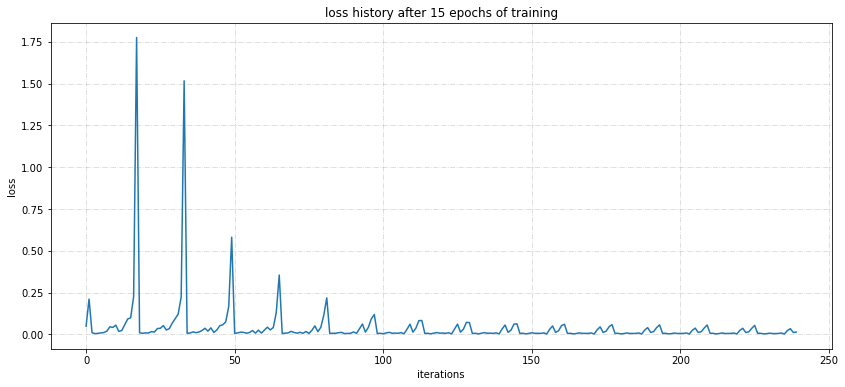

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.title(f'loss history after {epochs} epochs of training')
ax1.plot(loss_history)
ax1.grid(alpha=.5, linestyle='-.')
plt.xlabel('iterations')
plt.ylabel('loss')

In [28]:
real_labels = []
predicted_labels = []

with torch.no_grad():
    for i, (seq, label) in enumerate(test_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device) 
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        real_labels.append(label)
        predicted_labels.append(model(seq))
    
predicted_labels = np.array(predicted_labels)
real_labels = np.array(real_labels)

/home/eytan/miniconda/envs/data-science/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [29]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(real_labels, predicted_labels)

0.17779665

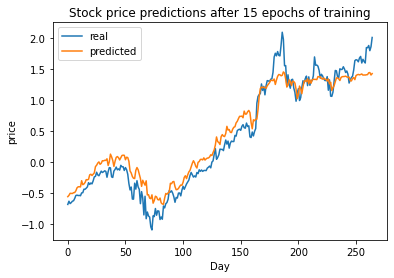

In [30]:

plt.title(f'Stock price predictions after {epochs} epochs of training')
plt.xlabel('Day')
plt.ylabel('price')
plt.plot(real_labels, label='real')
plt.plot(predicted_labels, label='predicted')
plt.legend();

# plt.savefig(f'/content/drive/My Drive/Deep Learning Final Project/{epochs}-epoch-preds1.jpg')

In [43]:
real_prices = real_labels * scaler.scale_[3] + scaler.mean_[3]
predicted_prices = predicted_labels * scaler.scale_[3] + scaler.mean_[3]

In [45]:
real_prices[-5:]

array([127.81, 128.7 , 126.66, 128.23, 131.88], dtype=float32)

In [46]:
predicted_prices[-5:]

array([117.18005, 117.91103, 118.00499, 117.03108, 117.58612],
      dtype=float32)

In [48]:
apple

,Open,High,Low,Close,Volume
Date,,,,,
2015-12-28,24.919764,24.942927,24.593184,24.741419,106816800
2015-12-29,24.773845,25.345942,24.750684,25.186125,123724800
2015-12-30,25.149068,25.176861,24.824803,24.857229,100855200
2015-12-31,24.785424,24.790055,24.278180,24.380093,163649200
2016-01-04,23.766309,24.405575,23.625022,24.400942,270597600
...,...,...,...,...,...
2020-12-16,127.410004,128.369995,126.559998,127.809998,98208600
2020-12-17,128.899994,129.580002,128.039993,128.699997,94359800
2020-12-18,128.960007,129.100006,126.120003,126.660004,192541500


In [49]:
# TODO SAVE THE MODEL